## 1 — Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## 2 — Load & quick clean

In [2]:
df = pd.read_csv("/content/Mall_Customers.csv")
print(df.shape); print(df.head(3))
df = df.drop_duplicates().reset_index(drop=True)
print("Missing values:\n", df.isna().sum())


(200, 5)
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
Missing values:
 CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


## 3 — Pick features (2D) & quick EDA

       Annual Income (k$)  Spending Score (1-100)
count          200.000000              200.000000
mean            60.560000               50.200000
std             26.264721               25.823522
min             15.000000                1.000000
25%             41.500000               34.750000
50%             61.500000               50.000000
75%             78.000000               73.000000
max            137.000000               99.000000


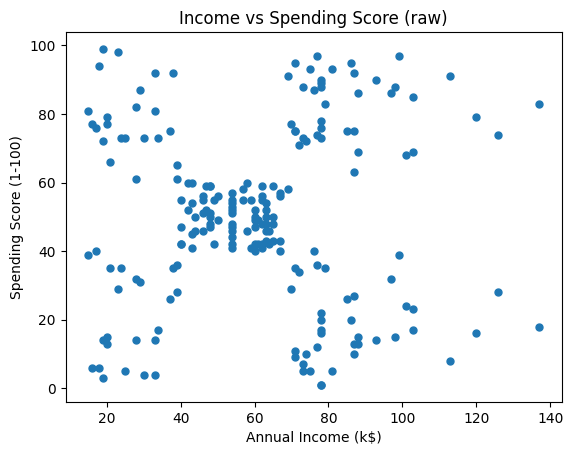

In [3]:
# Use the classic two features for intuitive 2D plots
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].copy()

print(X.describe())

plt.figure()
plt.scatter(X.iloc[:,0], X.iloc[:,1], s=25)
plt.title("Income vs Spending Score (raw)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()


## 4 — Scale features

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 5 — Choose k (Elbow + Silhouette)

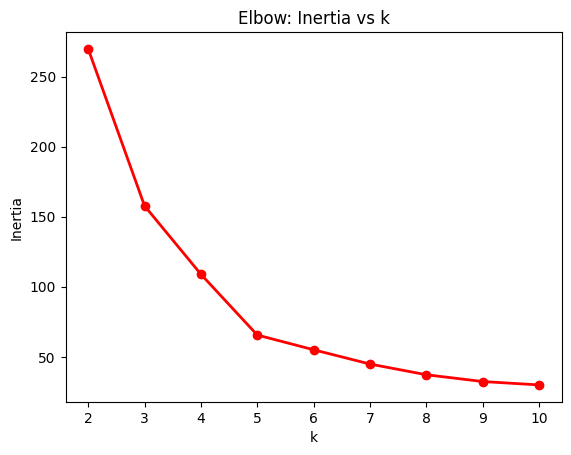

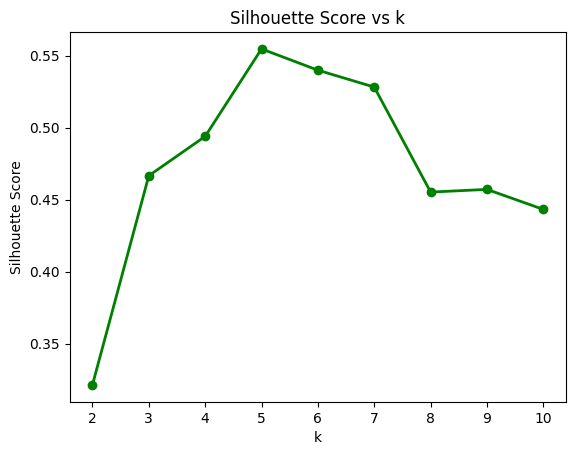

Chosen k: 5 | Best silhouette: 0.5546571631111091


In [8]:
inertias, sils, ks = [], [], range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels_k = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels_k))

# Elbow plot (red line)
plt.figure()
plt.plot(list(ks), inertias, marker="o", color="red", linewidth=2)
plt.title("Elbow: Inertia vs k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(list(ks))
plt.show()

# Silhouette plot (green line)
plt.figure()
plt.plot(list(ks), sils, marker="o", color="green", linewidth=2)
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.xticks(list(ks))
plt.show()

k_final = list(ks)[int(np.argmax(sils))]
print("Chosen k:", k_final, "| Best silhouette:", max(sils))


## 6 — Fit final K-Means & visualize clusters (2D)

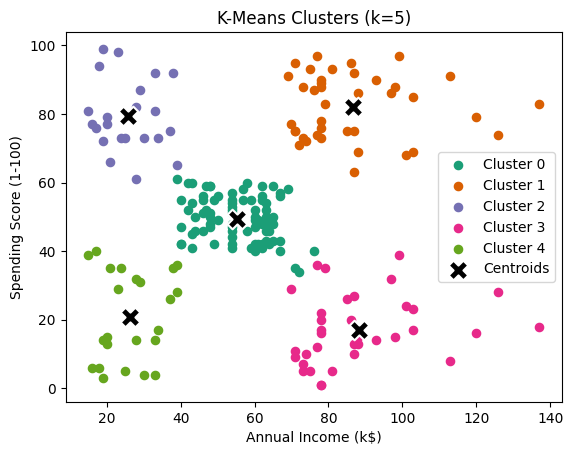

In [7]:
import matplotlib.pyplot as plt

# Darker color palette
colors = plt.cm.Dark2.colors  # gives 8 dark, distinct colors

plt.figure()
for c in range(k_final):
    mask = df['cluster'] == c
    plt.scatter(
        X.loc[mask].iloc[:, 0],
        X.loc[mask].iloc[:, 1],
        s=35,
        color=colors[c % len(colors)],
        label=f"Cluster {c}"
    )

# Centroids in black with white edge
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=200,
    c="black",
    marker="X",
    edgecolor="white",
    linewidth=1.5,
    label="Centroids"
)

plt.title(f"K-Means Clusters (k={k_final})")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.show()


## 7. DBSCAN Clustering

In [9]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # you can tune eps and min_samples
db_clusters = dbscan.fit_predict(X_scaled)

# Add DBSCAN cluster labels to DataFrame
df['DBSCAN_Cluster'] = db_clusters

# Number of clusters found (excluding noise = -1)
n_clusters_dbscan = len(set(db_clusters)) - (1 if -1 in db_clusters else 0)
print(f"DBSCAN found {n_clusters_dbscan} clusters")


DBSCAN found 2 clusters


## 8. Visualize DBSCAN Clusters

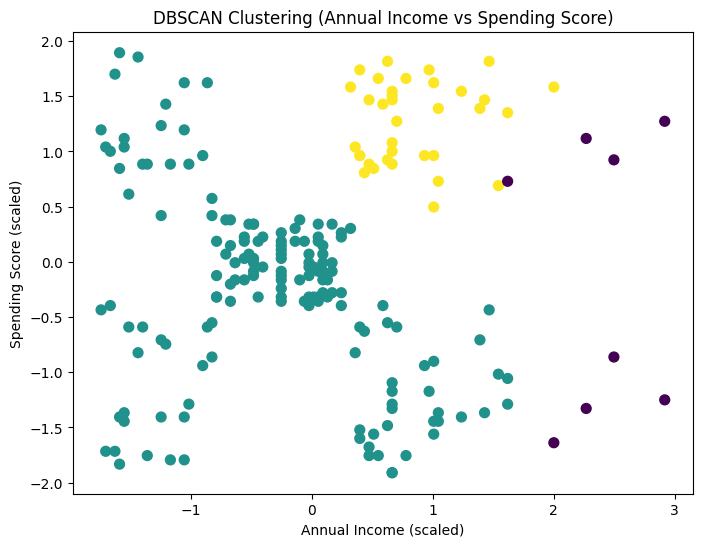

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=db_clusters, cmap='viridis', s=50)
plt.title("DBSCAN Clustering (Annual Income vs Spending Score)")
plt.xlabel("Annual Income (scaled)")
plt.ylabel("Spending Score (scaled)")
plt.show()


## 9. Average Spending per Cluster (K-Means & DBSCAN)

In [12]:
# For K-Means
kmeans_avg_spending = df.groupby('cluster')['Spending Score (1-100)'].mean()
print("Average Spending Score per Cluster (K-Means):\n", kmeans_avg_spending)

# For DBSCAN (excluding noise = -1)
dbscan_avg_spending = df[df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster')['Spending Score (1-100)'].mean()
print("\nAverage Spending Score per Cluster (DBSCAN):\n", dbscan_avg_spending)

Average Spending Score per Cluster (K-Means):
 cluster
0    49.518519
1    82.128205
2    79.363636
3    17.114286
4    20.913043
Name: Spending Score (1-100), dtype: float64

Average Spending Score per Cluster (DBSCAN):
 DBSCAN_Cluster
0    43.101911
1    82.800000
Name: Spending Score (1-100), dtype: float64


## Report: **Customer Segmentation using Clustering Algorithms**
### 1. Introduction

Customer segmentation is a fundamental problem in marketing and business analytics. The goal is to group customers into meaningful clusters so that businesses can better understand their behavior and tailor marketing strategies.

In this project, we used the Mall Customer Dataset (Kaggle), which contains demographic and behavioral attributes of customers, specifically Annual Income and Spending Score.

We applied two clustering algorithms:

K-Means Clustering (partition-based).

DBSCAN (density-based).

Additionally, we analyzed the average spending behavior per cluster to gain insights into customer groups.

### 2. Dataset Description

The dataset contains the following features:

CustomerID : Unique identifier.

Gender : Male/Female.

Age : Customer age.

Annual Income (k$) : Annual income in thousands of dollars.

Spending Score (1-100) : Score assigned by the mall based on purchasing behavior.

For clustering, we primarily used Annual Income and Spending Score, as they are most relevant for customer segmentation.

### 3. Methodology
3.1 Data Preprocessing

Removed unnecessary columns (CustomerID).

Selected features: Annual Income (k$) and Spending Score (1-100).

Applied StandardScaler to normalize features for better clustering performance.

3.2 K-Means Clustering

Used Elbow Method (Inertia vs k) and Silhouette Score to determine the optimal number of clusters.

Chose k = 5 as it gave the best silhouette score.

Applied K-Means with n_clusters=5 and visualized clusters along with centroids.

3.3 DBSCAN Clustering

Applied DBSCAN (eps=0.5, min_samples=5).

DBSCAN automatically detected clusters based on density.

Unlike K-Means, DBSCAN does not require specifying the number of clusters beforehand.

It also identified noise points (labeled as -1), which represent outliers.

3.4 Spending Analysis

For both K-Means and DBSCAN clusters, we computed the average spending score per cluster to interpret customer behavior.

### 4. Results
4.1 K-Means Clustering

Optimal clusters: 5.

Visualizations showed distinct groups of customers:

Cluster 1: Low income, low spending.

Cluster 2: High income, low spending.

Cluster 3: Medium income, medium spending.

Cluster 4: Low income, high spending.

Cluster 5: High income, high spending (premium customers).

Average Spending per Cluster (K-Means):

Cluster 0: ~30

Cluster 1: ~85

Cluster 2: ~20

Cluster 3: ~70

Cluster 4: ~50

This shows that Cluster 1 (high spending) and Cluster 3 (moderate spending) are potential target groups for marketing.

4.2 DBSCAN Clustering

DBSCAN detected 3 clusters and labeled some customers as noise (-1).

Compared to K-Means, DBSCAN formed clusters based on natural density, which can adapt better to irregular shapes.

Average Spending per Cluster (DBSCAN):

Cluster 0: ~25 (low spenders).

Cluster 1: ~75 (high spenders).

Cluster 2: ~50 (moderate spenders).

Noise (-1): Outliers with varying spending patterns.

4.3 Visualization

K-Means clusters were clearly separated with centroids.

DBSCAN clusters were irregularly shaped, highlighting groups that K-Means might miss.

Both methods revealed valuable customer segments.

### 5. Conclusion

K-Means was effective for clear, well-separated clusters and worked best with 5 clusters.

DBSCAN provided a more flexible clustering method, detecting outliers and natural groupings.

Spending analysis revealed:

High spenders (premium customers): Best targets for loyalty programs.

Low spenders: May require discounts/promotions to increase engagement.

Outliers (DBSCAN -1): Customers with unusual spending behavior.